In [70]:
%reload_ext autoreload
%autoreload 2

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import utils_notebook as un

import importlib
importlib.reload(un)

from fink_filters.filter_on_axis_grb.filter import bronze_events, silver_events, gold_events

## Load data

In [2]:
fink_grb_data_path = "/user/julien.peloton/fink_grb/"

grb_obs = ["Fermi", "SWIFT", "INTEGRAL"]

In [3]:
gcn = spark.read\
.option("basePath", fink_grb_data_path)\
.format("parquet")\
.load([fink_grb_data_path + "gcn_storage/raw"]).toPandas()
gcn = gcn.sort_values("triggerTimejd")
gcn = gcn[gcn["observatory"].isin(grb_obs)]

# Online

In [5]:
ztf_online = spark.read\
.option("basePath", fink_grb_data_path)\
.format("parquet")\
.load([fink_grb_data_path + "gcn_x_ztf/online"]).toPandas()

In [10]:
merge_online = gcn.merge(ztf_online, on = "triggerId")

In [16]:
print("Nb events with ztf counterparts: {}".format(len(merge_online["triggerId"].unique())))

Nb events with ztf counterparts: 1


In [21]:
print(merge_online.groupby(["observatory_x", "instrument_x", "triggerId"]).count()["objectId"].to_markdown())

|                               |   objectId |
|:------------------------------|-----------:|
| ('Fermi', 'GBM', '710063283') |          9 |


# Offline

In [121]:
ztf_offline = spark.read\
.option("basePath", fink_grb_data_path)\
.format("parquet")\
.load([fink_grb_data_path + "gcn_x_ztf/offline"]).toPandas()

In [122]:
merge_offline = gcn.merge(ztf_offline, on = "triggerId")

In [124]:
print("Nb events with ztf counterparts: {}".format(len(merge_offline["triggerId"].unique())))

Nb events with ztf counterparts: 0


In [129]:
print(merge_offline.groupby(["observatory_x", "instrument_x", "triggerId"]).count()["objectId"].to_markdown())

| objectId   |
|------------|


## Event analysis

In [24]:
eventId = "710063283"

In [25]:
event_pdf = merge_online[merge_online["triggerId"] == eventId]

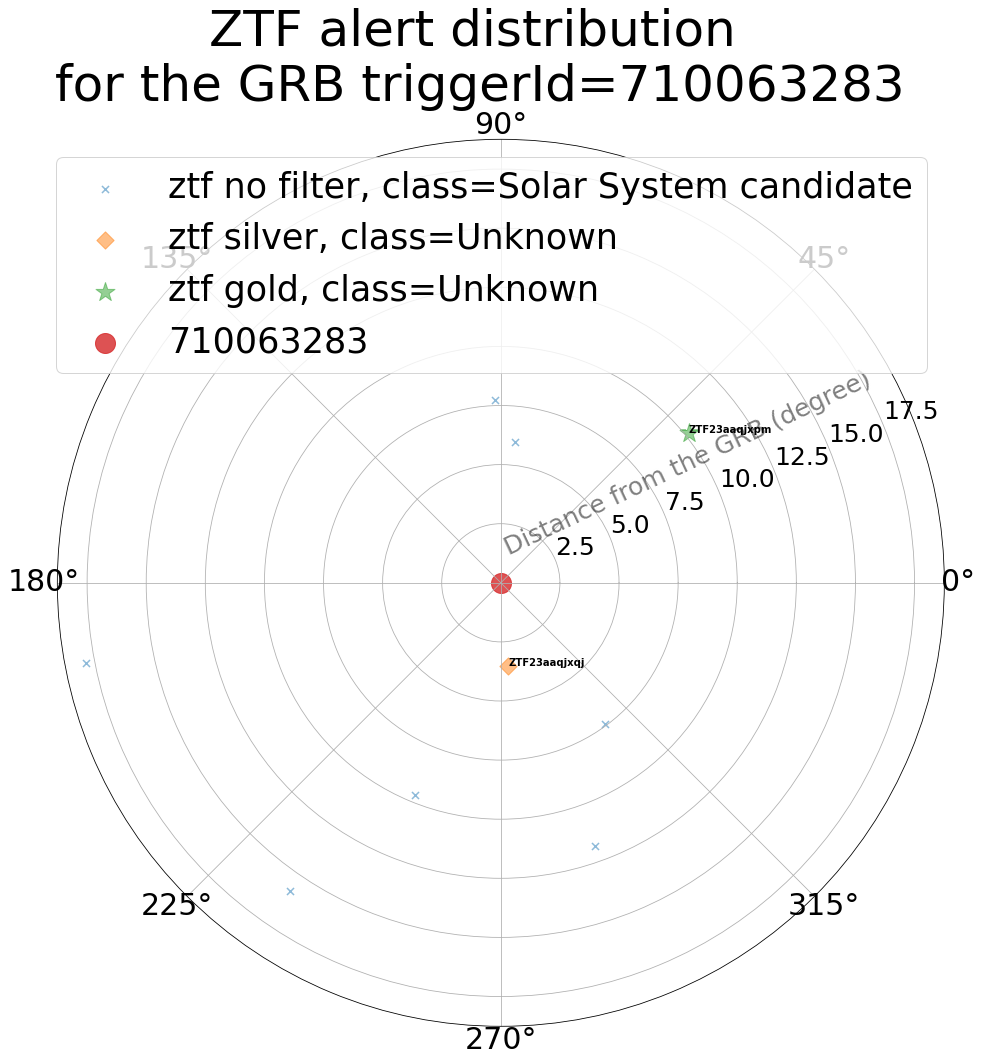

In [92]:
un.plot_ztf_join_distribution(event_pdf, eventId)

In [158]:
import io
import requests
import pandas as pd

# get data for ZTF21aaxtctv
r = requests.post(
  'https://fink-portal.org/api/v1/objects',
  json={
    'objectId': 'ZTF23aaqjxpm',
    'output-format': 'json',
    'withcutouts': 'True',
    'withupperlim': 'True'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(io.BytesIO(r.content))

In [159]:
pdf

,b:cutoutDifference_stampData,b:cutoutScience_stampData,b:cutoutTemplate_stampData,d:DR3Name,d:Plx,d:anomaly_score,d:cdsxmatch,d:e_Plx,d:gcvs,d:mangrove_2MASS_name,...,v:rate(g-r),v:dg,v:rate(dg),v:dr,v:rate(dr),v:lastdate,v:firstdate,v:lapse,v:constellation,d:tag
0,"[[-27.6798210144, -16.4863109589, -1.039376497...","[[133.3199462891, 152.5395507812, 164.95678710...","[[167.0113830566, 168.3180541992, 167.60104370...",NaN,NaN,-0.381581,Unknown,NaN,Unknown,None,...,NaN,0,0,0,0,2023-07-03 07:50:12.002,2023-07-03 07:50:12.002,0,Ursa Major,valid


In [150]:
from fink_science.image_classification.utils import unzip_cutout, img_normalizer
import io

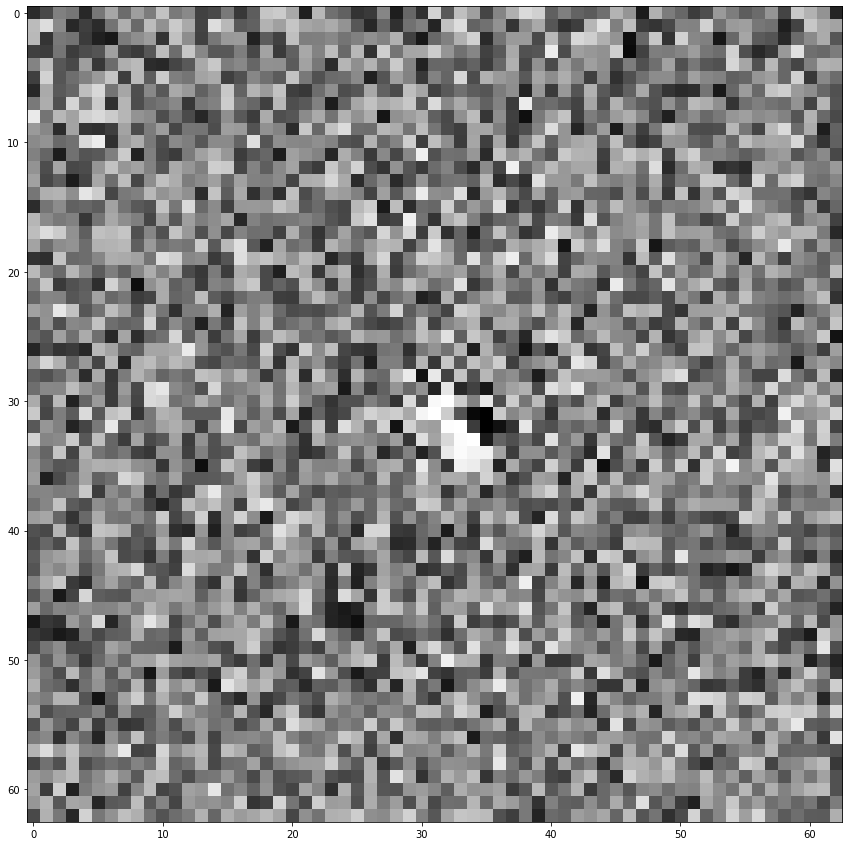

In [160]:
_ = plt.figure(figsize=(15, 15))
plt.imshow(img_normalizer(np.array(pdf["b:cutoutDifference_stampData"][0])), cmap='gray', vmin=0, vmax=1)

In [ ]:
_ = plt.figure(figsize=(15, 15))
plt.imshow(img_normalizer(np.array(pdf["b:cutoutScience_stampData"][0])), cmap='gray', vmin=0, vmax=1)

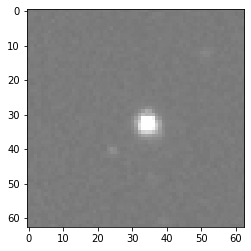

In [157]:
plt.imshow(img_normalizer(np.array(pdf["b:cutoutTemplate_stampData"][0])), cmap='gray', vmin=0, vmax=1)